In [9]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import os
import torch.nn as nn
import optuna
from lightgbm import LGBMRegressor, early_stopping


In [10]:
df_full = pd.read_parquet('./data/product_train_val_NN_TORCH.parquet', engine='fastparquet')

In [11]:
# Separar conjuntos
df_train = df_full[df_full['PERIODO'] <= 201908].copy()
df_val = df_full[(df_full['PERIODO'] == 201909)].copy()
df_test = df_full[(df_full['PERIODO'] == 201910)].copy()
df_pred = df_full[df_full['PERIODO'] == 201912].copy()
del df_full
gc.collect()

0

In [13]:
scaler_y = joblib.load('scaler_y_CLASE_LOG1P.joblib')

In [14]:
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador


In [15]:
def inv_transform_with_scaler(arr, scaler_y):
    arr = arr.reshape(-1, 1)
    log1p_vals = scaler_y.inverse_transform(arr).flatten()
    orig_vals = np.sign(log1p_vals) * np.expm1(np.abs(log1p_vals))
    return orig_vals

In [16]:
import gc
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- SETUP ---
target_col = 'CLASE_LOG1P_Z'
feature_cols = [col for col in df_train.columns if col != target_col]

X_tr = df_train[feature_cols]
y_tr = df_train[target_col]
X_val = df_val[feature_cols]
y_val = df_val[target_col]

In [17]:
def objective_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 512),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "linear_tree": trial.suggest_categorical("linear_tree", [True, False]),
        "random_state": trial.number,
        "n_jobs": -1,
        "verbosity": -1,
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=30, verbose=False)],
    )
    preds = model.predict(X_val)
    
    # Inversa de la transformación (log1p y escalado)
    y_val_orig = inv_transform_with_scaler(y_val.values, scaler_y)
    preds_orig = inv_transform_with_scaler(preds, scaler_y)

    # Evaluación con Total Forecast Error
    tfe = total_forecast_error(y_val_orig, preds_orig)
    trial.set_user_attr("mae", mean_absolute_error(y_val_orig, preds_orig))  # por si querés ver MAE también
    gc.collect()
    return tfe


In [18]:
# --- OPTIMIZE ---
N_MODELS = 50
N_TRIALS = 1000  

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=101))
study.optimize(objective_lgbm, n_trials=N_TRIALS, n_jobs=28, show_progress_bar=False)

# --- EXTRACT BEST 50 PARAMS ---
trials_df = study.trials_dataframe()
trials_df["mae"] = [t.user_attrs.get("mae", np.nan) for t in study.trials]

# Ahora la columna 'value' tiene el TFE, no el RMSE
top_lgbm_trials = trials_df.sort_values("value").head(N_MODELS)
final_configs = []
for i, row in top_lgbm_trials.iterrows():
    params = row.filter(like='params_').to_dict()
    params = {k.replace('params_', ''): v for k, v in params.items()}
    for p in ["num_leaves", "max_depth", "n_estimators", "min_child_samples"]:
        params[p] = int(params[p])
    params["random_state"] = int(row["number"])
    params["n_jobs"] = -1
    params["verbosity"] = -1
    final_configs.append(params)

# --- GUARDADO ---
top_lgbm_trials.to_csv("optuna_lgbm_trials.csv", index=False)
import json
with open("lgbm_ensemble_configs.json", "w") as f:
    json.dump(final_configs, f, indent=2)

# --- PRINT RESUMEN SIMPLE ---
print(f"Top 50 TFE (Total Forecast Error): {top_lgbm_trials['value'].head(50).values}")
print(f"Top 50 MAE: {top_lgbm_trials['mae'].head(50).values}")
print(final_configs)


[I 2025-07-15 02:04:01,532] A new study created in memory with name: no-name-ecc359cb-3cb8-4405-899e-8b0e0aa38584
[I 2025-07-15 02:04:06,168] Trial 18 finished with value: 0.24367500577455203 and parameters: {'learning_rate': 0.23863958904875368, 'num_leaves': 320, 'max_depth': 30, 'n_estimators': 407, 'min_child_samples': 60, 'subsample': 0.7382079109498942, 'colsample_bytree': 0.778343499347703, 'reg_alpha': 0.0015647668038082131, 'reg_lambda': 1.319943125230904e-06, 'min_split_gain': 0.29884270734898566, 'linear_tree': False}. Best is trial 18 with value: 0.24367500577455203.
[I 2025-07-15 02:04:06,878] Trial 0 finished with value: 0.252800856856042 and parameters: {'learning_rate': 0.18434494832492082, 'num_leaves': 258, 'max_depth': 16, 'n_estimators': 804, 'min_child_samples': 34, 'subsample': 0.7885844924254763, 'colsample_bytree': 0.9103813111263993, 'reg_alpha': 0.1166398240929373, 'reg_lambda': 0.00016037073635952553, 'min_split_gain': 0.7579274119758795, 'linear_tree': False

Top 50 TFE (Total Forecast Error): [0.21852019 0.21980572 0.22114377 0.22148808 0.22149376 0.22154091
 0.22162894 0.22195676 0.22246699 0.22251219 0.22276798 0.22279362
 0.22295021 0.22304687 0.22342167 0.22347885 0.22349616 0.22354864
 0.22373997 0.22390283 0.22397287 0.22407036 0.22413843 0.22414674
 0.22426441 0.22426895 0.22443519 0.22444147 0.22444668 0.22447233
 0.22452972 0.22457873 0.22459904 0.22464145 0.22467475 0.22478936
 0.2248043  0.22480564 0.22509855 0.22511107 0.22512191 0.22514325
 0.22516308 0.22517979 0.22518183 0.22521582 0.22522349 0.22523097
 0.22532691 0.22536612]
Top 50 MAE: [9.00050972 9.05345842 9.10857076 9.12275231 9.12298631 9.12492844
 9.12855417 9.14205675 9.16307231 9.16493386 9.1754694  9.1765256
 9.18297518 9.18695669 9.20239403 9.20474901 9.20546219 9.20762365
 9.21550431 9.22221236 9.22509701 9.22911255 9.23191615 9.23225838
 9.2371052  9.23729228 9.24413926 9.24439797 9.24461276 9.24566914
 9.24803295 9.25005139 9.25088805 9.25263495 9.25400632 9.2

In [19]:
X_full = pd.concat([df_train, df_val], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col]], ignore_index=True)

In [20]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"

results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 6/50...
Entrenando modelo 3/50...
Entrenando modelo 2/50...
Entrenando modelo 7/50...
Entrenando modelo 9/50...
Entrenando modelo 5/50...
Entrenando modelo 15/50...
Entrenando modelo 20/50...
Entrenando modelo 10/50...
Entrenando modelo 1/50...Entrenando modelo 18/50...

Entrenando modelo 4/50...
Entrenando modelo 14/50...
Entrenando modelo 8/50...
Entrenando modelo 12/50...
Entrenando modelo 13/50...
Entrenando modelo 16/50...
Entrenando modelo 19/50...
Entrenando modelo 11/50...
Entrenando modelo 17/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [21]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)


In [23]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_test.columns if col != target_col]

X_pred_lgbm = df_test[feature_cols]  # Si podés, asegurate que están en el mismo orden y tipo que en train

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_test[f'lgbm_pred_LOG1P_Z_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [26]:
import numpy as np

# Seleccioná las columnas de predicción
lgbm_pred_cols = [col for col in df_test.columns if col.startswith('lgbm_pred_LOG1P_Z_')]

# Calcula métricas fila a fila
df_test['lgbm_pred_mean'] = df_test[lgbm_pred_cols].mean(axis=1)
df_test['lgbm_pred_median'] = df_test[lgbm_pred_cols].median(axis=1)
df_test['lgbm_pred_std'] = df_test[lgbm_pred_cols].std(axis=1)
df_test['lgbm_pred_q25'] = df_test[lgbm_pred_cols].quantile(0.25, axis=1)
df_test['lgbm_pred_q75'] = df_test[lgbm_pred_cols].quantile(0.75, axis=1)
df_test['lgbm_pred_min'] = df_test[lgbm_pred_cols].min(axis=1)
df_test['lgbm_pred_max'] = df_test[lgbm_pred_cols].max(axis=1)
df_test['lgbm_pred_iqr'] = df_test['lgbm_pred_q75'] - df_test['lgbm_pred_q25']


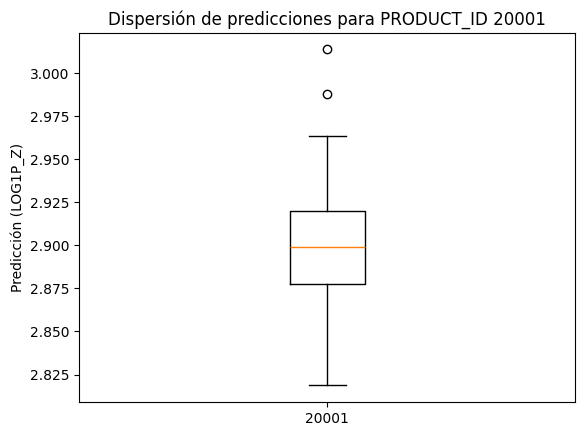

In [28]:
import matplotlib.pyplot as plt

producto_ejemplo = 20001  # Cambia por el PRODUCT_ID que quieras analizar

vals = df_test[df_test['PRODUCT_ID'] == producto_ejemplo][lgbm_pred_cols].values.flatten()

plt.boxplot([vals])
plt.title(f'Dispersión de predicciones para PRODUCT_ID {producto_ejemplo}')
plt.ylabel('Predicción (LOG1P_Z)')
plt.xticks([1], [str(producto_ejemplo)])
plt.show()


/tmp/ipykernel_55495/2941514620.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)


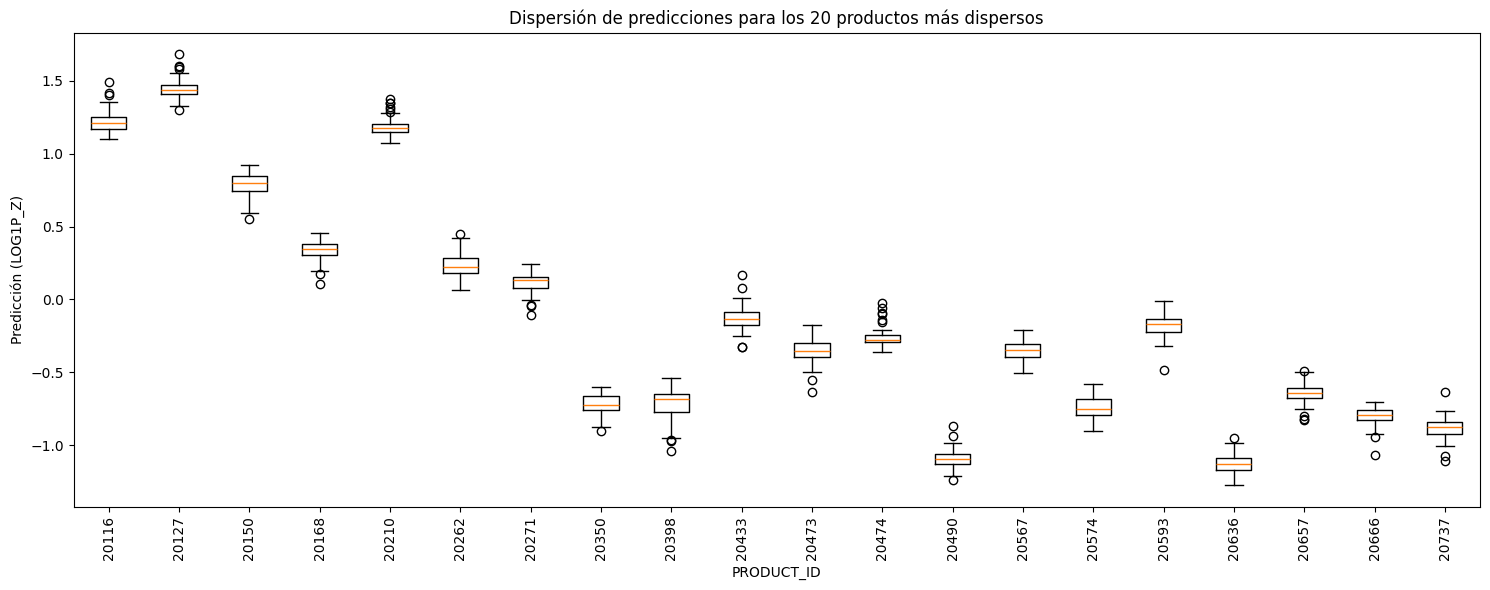

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tu df_test ya está cargado
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_Z_')]

# Calcula la dispersión (std) para cada producto
df_test['pred_std'] = df_test[pred_cols].std(axis=1)
top_n = 20
productos_disp = df_test.sort_values('pred_std', ascending=False)['PRODUCT_ID'].unique()[:top_n]

# Subset de los productos seleccionados
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()
df_plot = df_plot[['PRODUCT_ID'] + pred_cols]

# Boxplots
plt.figure(figsize=(15, 6))
data = df_plot.iloc[:, 1:].values  # Todas las filas, columnas excepto la primera (PRODUCT_ID)
plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (LOG1P_Z)')
plt.title(f'Dispersión de predicciones para los {top_n} productos más dispersos')
plt.tight_layout()
plt.show()


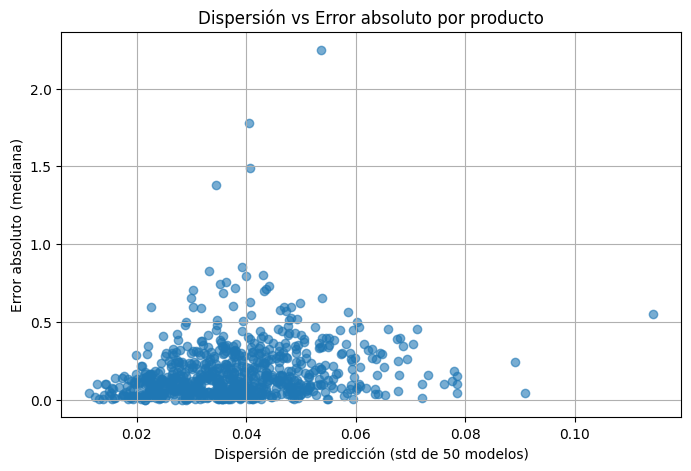

In [32]:
# Calcula la predicción central y la dispersión
df_test['pred_median'] = df_test[pred_cols].median(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# Error absoluto respecto al real
df_test['abs_err_median'] = (df_test['pred_median'] - df_test['CLASE_LOG1P_Z']).abs()
df_test['abs_err_mean'] = (df_test['pred_mean'] - df_test['CLASE_LOG1P_Z']).abs()

plt.figure(figsize=(8,5))
plt.scatter(df_test['pred_std'], df_test['abs_err_median'], alpha=0.6)
plt.xlabel('Dispersión de predicción (std de 50 modelos)')
plt.ylabel('Error absoluto (mediana)')
plt.title('Dispersión vs Error absoluto por producto')
plt.grid(True)
plt.show()


In [33]:
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_Z_')]
df_test['CLASE_TN'] = inv_transform_with_scaler(df_test['CLASE_LOG1P_Z'].values, scaler_y)
# Tomar las 50 columnas como una matriz
preds_scaled = df_test[pred_cols].values  # shape (n, 50)
# Invertir la transformación para cada columna
preds_inv = scaler_y.inverse_transform(preds_scaled)  # shape (n, 50)
preds_orig = np.expm1(preds_inv)  # Deshace log1p

# Crear nuevas columnas en el DataFrame con los valores originales
for i, col in enumerate(pred_cols):
    df_test[col.replace('LOG1P_Z', 'TN')] = preds_orig[:, i]


/tmp/ipykernel_55495/10215352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P_Z', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_55495/10215352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P_Z', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_55495/10215352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [34]:
# Las nuevas columnas de predicción en escala original
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]
df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
df_test['abs_error_median_tn'] = np.abs(df_test['pred_median_tn'] - df_test['CLASE_TN'])


/tmp/ipykernel_55495/2174904353.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
/tmp/ipykernel_55495/2174904353.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_55495/2174904353.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

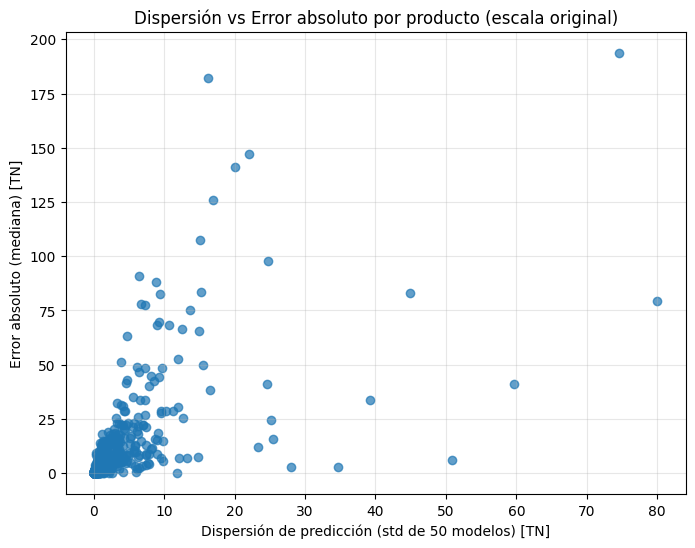

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_test['pred_std_tn'], df_test['abs_error_median_tn'], alpha=0.7)
plt.xlabel('Dispersión de predicción (std de 50 modelos) [TN]')
plt.ylabel('Error absoluto (mediana) [TN]')
plt.title('Dispersión vs Error absoluto por producto (escala original)')
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipykernel_55495/3445462354.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_plot['PRODUCT_ID'], showfliers=True)


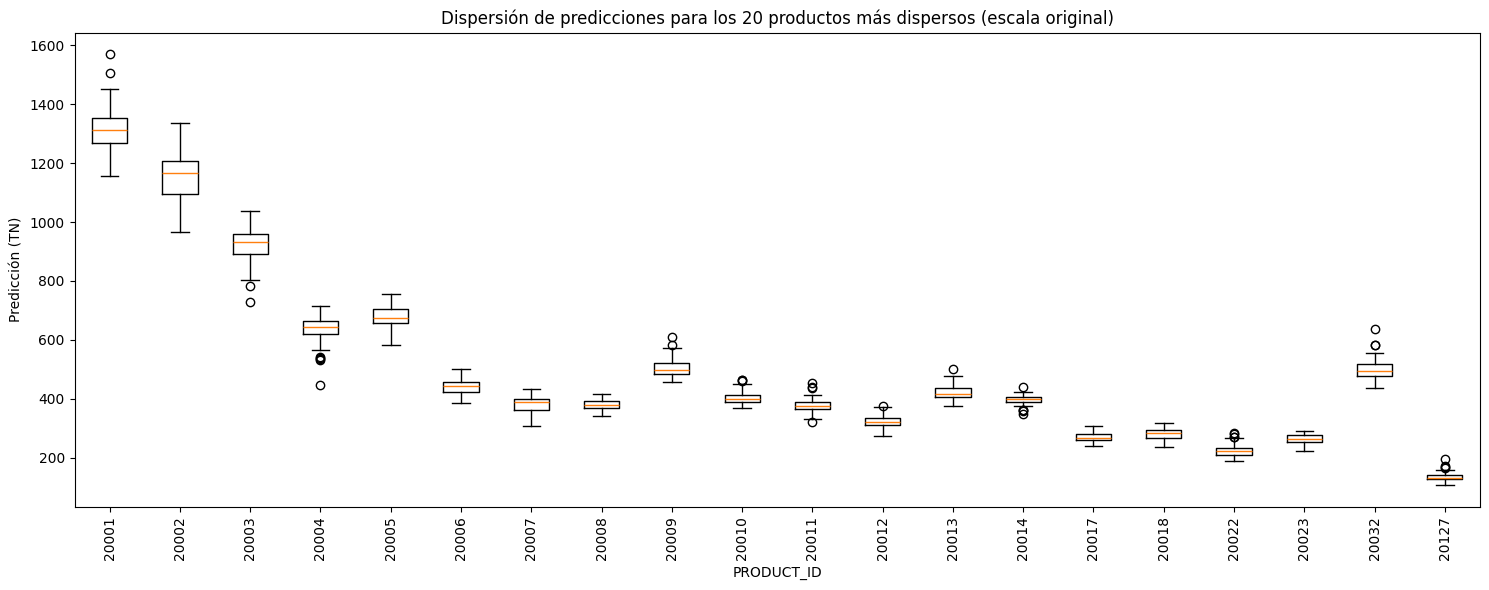

In [36]:
# Top N más dispersos
top_n = 20
productos_disp = df_test.sort_values('pred_std_tn', ascending=False)['PRODUCT_ID'].unique()[:top_n]
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()
df_plot = df_plot[['PRODUCT_ID'] + pred_cols_tn]

plt.figure(figsize=(15, 6))
data = [row[1:] for row in df_plot.values]  # omite PRODUCT_ID
plt.boxplot(data, labels=df_plot['PRODUCT_ID'], showfliers=True)
plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (TN)')
plt.title(f'Dispersión de predicciones para los {top_n} productos más dispersos (escala original)')
plt.tight_layout()
plt.show()


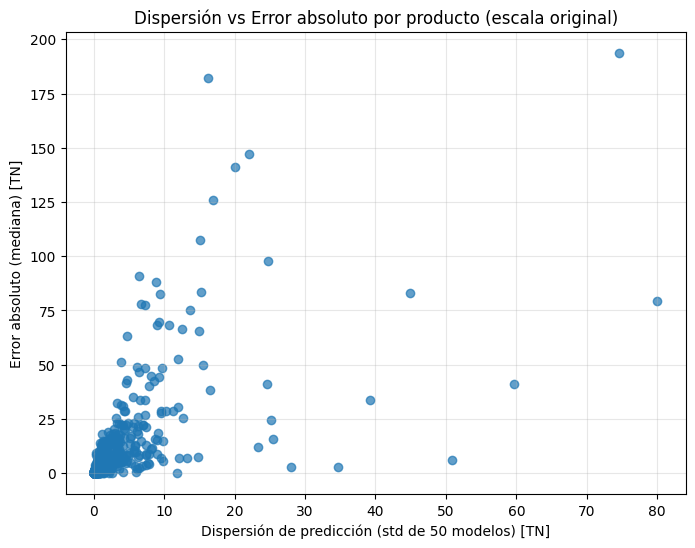

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(df_test['pred_std_tn'], df_test['abs_error_median_tn'], alpha=0.7)
plt.xlabel('Dispersión de predicción (std de 50 modelos) [TN]')
plt.ylabel('Error absoluto (mediana) [TN]')
plt.title('Dispersión vs Error absoluto por producto (escala original)')
plt.grid(True, alpha=0.3)
plt.show()


In [42]:
print(df_test.columns.to_list())

['PERIODO', 'MES_SIN', 'MES_COS', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'MES_PROBLEMATICO', 'IS_FEBRERO', 'ESTOY_PREDICIENDO_FEBRERO', 'CAIDA_ABRUPTA', 'CLASE_LOG1P_Z', 'PRODUCT_RANK_BIN', 'ORDINAL_Z', 'ANIO_Z', 'MES_Z', 'TRIMESTRE_Z', 'PRODUCT_ID_Z', 'TN_Z', 'PROM_ULT_3_FEBREROS_Z', 'DIF_TN_VS_FEBREROS_ULT_3_Z', 'TN_MAX_HISTORICO_Z', 'TN_DIST_A_MAX_HIST_Z', 'TN_RATIO_VS_MAX_HIST_Z', 'TN_MEAN_03_Z', 'PENDIENTE_TENDENCIA_3_Z', 'TN_EWMA_03_Z', 'TN_MEDIAN_03_Z', 'TN_MIN_03_Z', 'TN_MAX_03_Z', 'TN_STD_03_Z', 'TN_SKEW_03_Z', 'TN_KURT_03_Z', 'TN_GROWTH_03_Z', 'TN_IQR_03_Z', 'TN_SUM_03_Z', 'TN_COUNT_POS_03_Z', 'TN_PCT_ZERO_03_Z', 'TN_LAST_03_Z', 'TN_LAST_DIFF_03_Z', 'TN_COEF_VAR_3_Z', 'TN_MAXMIN_RATIO_3_Z', 'TN_RANGO_3_Z', 'TN_RANGO_REL_3_Z', 'TN_LAST_VS_MEDIAN_3_Z', 'TN_CHANGE_PREV_WINDOW_3_Z', 'TN_ZEROS_END_3_Z', 'TN_LAST_PCT_SUM_3_Z', 'TN_PCT90_3_Z', 'TN_PCT10_3_Z', 'TN_PCT_WIDTH_3_Z', 'TN_MINUS_MEAN_03_Z', 'TN_MINUS_MEDIAN_03_Z', 'TN_MINUS_EWMA_03_Z', 'TN_O

In [43]:
top_n = 10

# Top por dispersión
top_disp = df_test.sort_values('pred_std_tn', ascending=False).head(top_n)
print("Top 10 productos por dispersión:")
print(top_disp[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])

# Top por error absoluto
top_error = df_test.sort_values('abs_error_median_tn', ascending=False).head(top_n)
print("\nTop 10 productos por error absoluto:")
print(top_error[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])



Top 10 productos por dispersión:
      PRODUCT_ID  pred_std_tn  abs_error_median_tn    CLASE_TN
38         20002    80.033539            79.187005  1087.30855
2          20001    74.593269           193.575411  1504.68856
74         20003    59.691906            41.110808   891.25641
110        20004    50.801764             6.216496   637.84826
146        20005    44.905654            83.050713   592.53573
1118       20032    39.222249            33.961305   527.79811
290        20009    34.715502             2.645868   495.03574
218        20007    28.055914             2.882745   390.43432
362        20011    25.457784            15.646643   392.25186
182        20006    25.135844            24.600470   417.23228

Top 10 productos por error absoluto:
      PRODUCT_ID  pred_std_tn  abs_error_median_tn    CLASE_TN
2          20001    74.593269           193.575411  1504.68856
254        20008    16.238514           182.374884   195.36854
398        20012    22.107148           147.253

/tmp/ipykernel_55495/2685728009.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([preds], labels=[f'PRODUCT {product_id}'], showfliers=True)


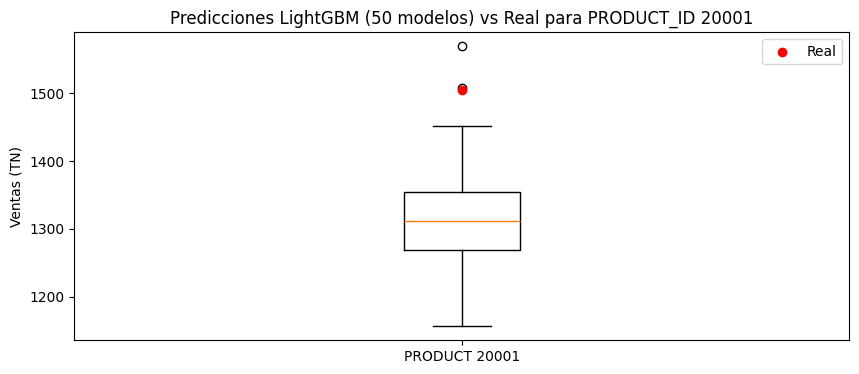

In [49]:
import matplotlib.pyplot as plt

def plot_preds_for_product(df, product_id):
    subset = df[df['PRODUCT_ID'] == product_id]
    pred_cols = [c for c in df.columns if c.startswith('lgbm_pred_TN_')]
    preds = subset[pred_cols].values.flatten()
    real = subset['CLASE_TN'].values[0]
    plt.figure(figsize=(10, 4))
    plt.boxplot([preds], labels=[f'PRODUCT {product_id}'], showfliers=True)
    plt.scatter(1, real, color='red', label='Real', zorder=10)
    plt.ylabel('Ventas (TN)')
    plt.title(f'Predicciones LightGBM (50 modelos) vs Real para PRODUCT_ID {product_id}')
    plt.legend()
    plt.show()

# Para el producto con más dispersión
plot_preds_for_product(df_test, 20001)


In [50]:
import numpy as np
import pandas as pd

# 1. Identificá las columnas de predicción
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]

# 2. Calculá media y mediana de las predicciones
df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)

# 3. Calculá el MAE para ambas estrategias
mae_median = np.mean(np.abs(df_test['ensemble_median'] - df_test['CLASE_TN']))
mae_mean   = np.mean(np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN']))

print(f"MAE usando la **mediana** de 50 modelos: {mae_median:.3f} TN")
print(f"MAE usando la **media** de 50 modelos:   {mae_mean:.3f} TN")

# 4. Si querés comparar producto por producto:
df_test['error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])
df_test['error_mean']   = np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN'])

print("\nTop 10 productos donde la media le gana a la mediana:")
print(df_test[df_test['error_mean'] < df_test['error_median']][['PRODUCT_ID', 'error_median', 'error_mean']].sort_values('error_median', ascending=False).head(10))


MAE usando la **mediana** de 50 modelos: 7.768 TN
MAE usando la **media** de 50 modelos:   7.742 TN

Top 10 productos donde la media le gana a la mediana:
      PRODUCT_ID  error_median  error_mean
2          20001    193.575411  188.147172
614        20018    141.167097  138.844674
470        20014    125.970033  124.178166
2706       20085     82.427419   81.804574
38         20002     79.187005   61.846216
4271       20143     77.352873   76.937558
1129       20033     69.645221   69.166366
830        20024     68.440010   67.888918
938        20027     68.227019   66.626124
1201       20037     66.335412   63.905461


/tmp/ipykernel_55495/245051272.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_55495/245051272.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)
/tmp/ipykernel_55495/245051272.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

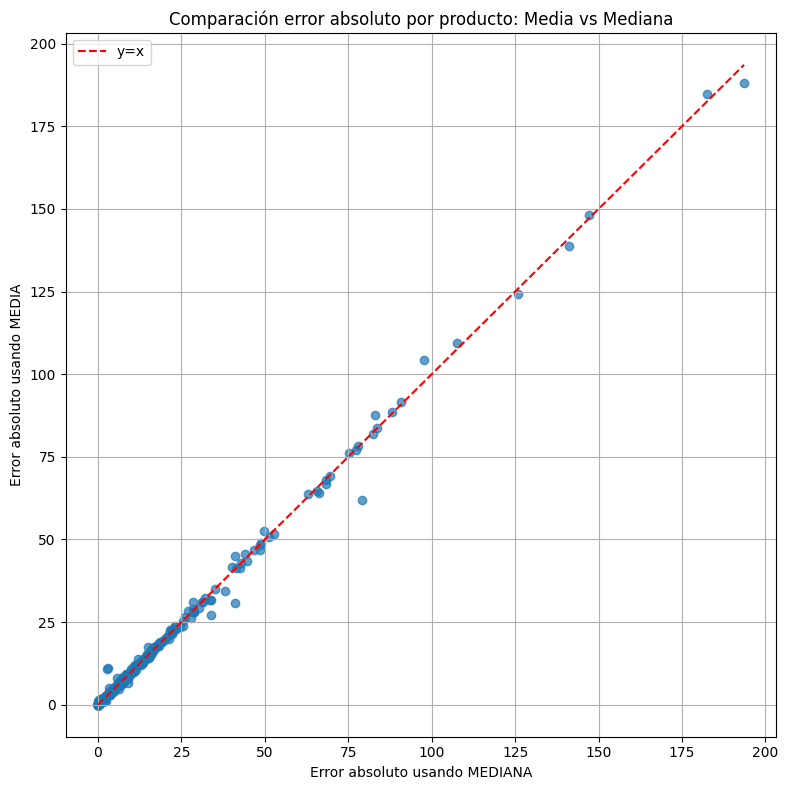

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df_test['error_median'], df_test['error_mean'], alpha=0.7)
plt.plot([df_test['error_median'].min(), df_test['error_median'].max()],
         [df_test['error_median'].min(), df_test['error_median'].max()], 'r--', label='y=x')
plt.xlabel('Error absoluto usando MEDIANA')
plt.ylabel('Error absoluto usando MEDIA')
plt.title('Comparación error absoluto por producto: Media vs Mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


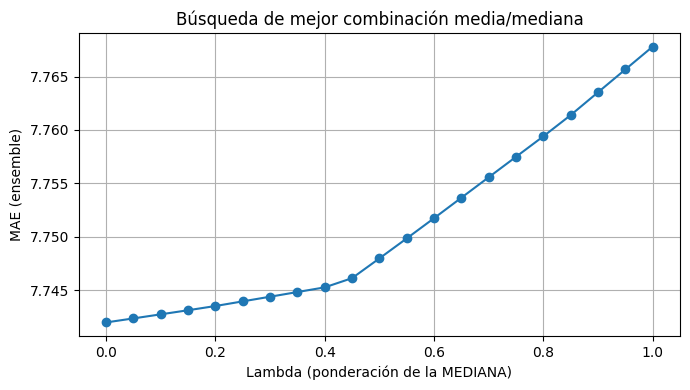

Mejor lambda = 0.00 (MAE=7.742 TN)


In [52]:
import numpy as np

lambdas = np.linspace(0, 1, 21)
maes = []

for l in lambdas:
    pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    mae = np.mean(np.abs(pred - df_test['CLASE_TN']))
    maes.append(mae)

plt.figure(figsize=(7, 4))
plt.plot(lambdas, maes, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('MAE (ensemble)')
plt.title('Búsqueda de mejor combinación media/mediana')
plt.grid(True)
plt.tight_layout()
plt.show()

best_lambda = lambdas[np.argmin(maes)]
print(f"Mejor lambda = {best_lambda:.2f} (MAE={min(maes):.3f} TN)")


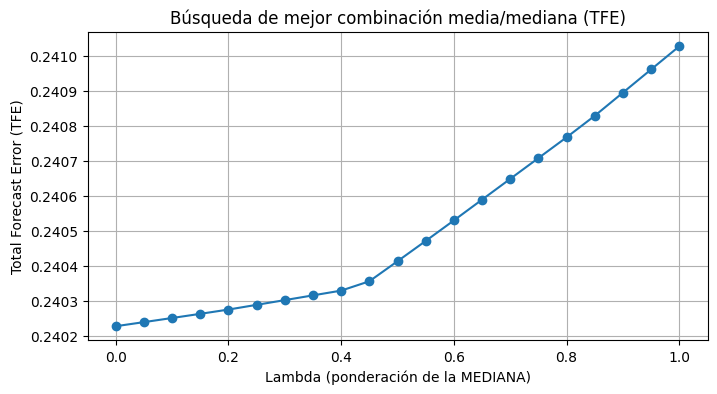

Mejor lambda: 0.00  ->  TFE = 0.240227


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Tu función de métrica
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador 

# Suponiendo que en tu df_test ya tenés:
# 'ensemble_median', 'ensemble_mean', y la observación real 'CLASE_TN'
lambdas = np.linspace(0, 1, 21)
tfe_scores = []

for l in lambdas:
    y_pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    tfe = total_forecast_error(df_test['CLASE_TN'].values, y_pred.values)
    tfe_scores.append(tfe)

plt.figure(figsize=(8, 4))
plt.plot(lambdas, tfe_scores, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('Total Forecast Error (TFE)')
plt.title('Búsqueda de mejor combinación media/mediana (TFE)')
plt.grid(True)
plt.show()

# Mejor lambda encontrado y su TFE
best_idx = np.argmin(tfe_scores)
print(f"Mejor lambda: {lambdas[best_idx]:.2f}  ->  TFE = {tfe_scores[best_idx]:.6f}")


In [54]:
# Calcula el TFE por producto usando media y mediana
tfe_prod_median = []
tfe_prod_mean = []

for pid, subdf in df_test.groupby('PRODUCT_ID'):
    tfe_median = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_median'].values)
    tfe_mean = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_mean'].values)
    tfe_prod_median.append((pid, tfe_median))
    tfe_prod_mean.append((pid, tfe_mean))

df_tfe = pd.DataFrame({
    'PRODUCT_ID': [pid for pid, _ in tfe_prod_median],
    'TFE_median': [tfe for _, tfe in tfe_prod_median],
    'TFE_mean': [tfe for _, tfe in tfe_prod_mean]
})
df_tfe['TFE_diff'] = df_tfe['TFE_median'] - df_tfe['TFE_mean']

# Top 10 productos donde la media mejora más vs la mediana
print(df_tfe.sort_values('TFE_diff', ascending=False).head(10))


     PRODUCT_ID  TFE_median  TFE_mean  TFE_diff
751       21192    3.499971  2.516405  0.983567
746       21180    3.573746  2.665281  0.908465
770       21248    3.612162  2.823025  0.789137
779       21276    6.702629  6.044333  0.658296
762       21222    1.648960  1.120027  0.528934
775       21263    3.083234  2.578406  0.504828
772       21256    3.133947  2.724786  0.409161
766       21233    0.998134  0.632853  0.365281
769       21246    1.403072  1.052484  0.350587
756       21202    0.452154  0.118622  0.333532


In [55]:
# Top productos donde la mediana es mejor que la media
print(df_tfe[df_tfe['TFE_diff'] < 0].sort_values('TFE_diff').head(10))


     PRODUCT_ID  TFE_median    TFE_mean   TFE_diff
705       21074  405.626060  416.025100 -10.399040
761       21218    0.096490    0.697749  -0.601259
89        20100   56.421234   56.774844  -0.353610
273       20334   95.952939   96.157640  -0.204701
532       20721   20.458541   20.606660  -0.148119
748       21184    0.419889    0.541354  -0.121465
737       21159    1.876547    1.982513  -0.105966
449       20601    2.046101    2.140231  -0.094131
630       20913    0.706036    0.797128  -0.091093
72        20080   10.264256   10.355072  -0.090816


In [56]:
X_full = pd.concat([df_train, df_val,df_test], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col],df_test[target_col]], ignore_index=True)

In [57]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"

results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 3/50...
Entrenando modelo 6/50...
Entrenando modelo 8/50...
Entrenando modelo 5/50...
Entrenando modelo 1/50...
Entrenando modelo 4/50...Entrenando modelo 2/50...

Entrenando modelo 7/50...
Entrenando modelo 13/50...
Entrenando modelo 16/50...
Entrenando modelo 17/50...
Entrenando modelo 10/50...
Entrenando modelo 12/50...
Entrenando modelo 15/50...
Entrenando modelo 20/50...
Entrenando modelo 19/50...
Entrenando modelo 14/50...
Entrenando modelo 9/50...
Entrenando modelo 18/50...
Entrenando modelo 11/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [59]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)

In [62]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_pred.columns if col != target_col]

X_pred_lgbm = df_pred[feature_cols]  

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_pred[f'lgbm_pred_LOG1P_Z_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [63]:
# Crear columnas nuevas con sufijo "_ORIG"
for col in df_pred.columns:
    if col not in ['CUSTOMER_ID', 'PRODUCT_ID']:
        arr = df_pred[col].values
        df_pred[col.replace('_LOG1P_Z_', '_ORIG_')] = inv_transform_with_scaler(arr, scaler_y)

/tmp/ipykernel_55495/508272763.py:4: RuntimeWarning: overflow encountered in expm1
  orig_vals = np.sign(log1p_vals) * np.expm1(np.abs(log1p_vals))
/tmp/ipykernel_55495/955500967.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('_LOG1P_Z_', '_ORIG_')] = inv_transform_with_scaler(arr, scaler_y)
/tmp/ipykernel_55495/955500967.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('_LOG1P_Z_', '_ORIG_')] = inv_transform_with_scaler(arr, scaler_y)
/tmp/ipykernel_55495/955500967.py:5: Performan

In [64]:
# Eliminar de df_preds_final las columnas con "_LOG1P_Z_"
cols_to_remove = [col for col in df_pred.columns if '_LOG1P_Z_' in col]
df_pred.drop(columns=cols_to_remove, inplace=True)

In [69]:
lgbm_cols = [c for c in df_pred.columns if c.startswith('lgbm_pred_ORIG_')]
print(lgbm_cols)

['lgbm_pred_ORIG_1', 'lgbm_pred_ORIG_2', 'lgbm_pred_ORIG_3', 'lgbm_pred_ORIG_4', 'lgbm_pred_ORIG_5', 'lgbm_pred_ORIG_6', 'lgbm_pred_ORIG_7', 'lgbm_pred_ORIG_8', 'lgbm_pred_ORIG_9', 'lgbm_pred_ORIG_10', 'lgbm_pred_ORIG_11', 'lgbm_pred_ORIG_12', 'lgbm_pred_ORIG_13', 'lgbm_pred_ORIG_14', 'lgbm_pred_ORIG_15', 'lgbm_pred_ORIG_16', 'lgbm_pred_ORIG_17', 'lgbm_pred_ORIG_18', 'lgbm_pred_ORIG_19', 'lgbm_pred_ORIG_20', 'lgbm_pred_ORIG_21', 'lgbm_pred_ORIG_22', 'lgbm_pred_ORIG_23', 'lgbm_pred_ORIG_24', 'lgbm_pred_ORIG_25', 'lgbm_pred_ORIG_26', 'lgbm_pred_ORIG_27', 'lgbm_pred_ORIG_28', 'lgbm_pred_ORIG_29', 'lgbm_pred_ORIG_30', 'lgbm_pred_ORIG_31', 'lgbm_pred_ORIG_32', 'lgbm_pred_ORIG_33', 'lgbm_pred_ORIG_34', 'lgbm_pred_ORIG_35', 'lgbm_pred_ORIG_36', 'lgbm_pred_ORIG_37', 'lgbm_pred_ORIG_38', 'lgbm_pred_ORIG_39', 'lgbm_pred_ORIG_40', 'lgbm_pred_ORIG_41', 'lgbm_pred_ORIG_42', 'lgbm_pred_ORIG_43', 'lgbm_pred_ORIG_44', 'lgbm_pred_ORIG_45', 'lgbm_pred_ORIG_46', 'lgbm_pred_ORIG_47', 'lgbm_pred_ORIG_48', 

In [70]:
df_pred['lgbm_mean'] = df_pred[lgbm_cols].mean(axis=1)


/tmp/ipykernel_55495/635811909.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred['lgbm_mean'] = df_pred[lgbm_cols].mean(axis=1)


In [72]:
df_pred['lgbm_mean'] = df_pred['lgbm_mean'].clip(lower=0)

df_pred[['PRODUCT_ID', 'lgbm_mean']]\
    .rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_mean': 'tn'})\
    .to_csv('lgbm_predictions.csv', index=False)
